# Quality Control (QC)

An initial analysis to evaluate the quality of the reads resulting from the experiment is highly recommended. For this, NanoDJ relies on the Python programming language and the [BioPython](https://biopython.org/) module to evaluate the quality of basecalls, and the number, length and GC content of the reads. Processing the data using Python and this module allows greater control when filtering or visualizing the data.

The Biopython package uses the SeqIO module, which provides an interface to input and output assorted sequence files (as FASTA/FASTQ). Sequences are sorted as SeqRecord objects, a data structure for sequences that can also store more information than the sequence itself and makes it easy to get some interesting metrics such as the Phred score. Other data science modules like numpy and pandas are used to process the data as a table and the module matplotlib to generate visualizations of the data.
  

In [1]:
#Biopython module imports for loading sequence files
from Bio import SeqIO
from Bio.SeqUtils import GC

#Numpy and pandas to manage the data
import numpy as np
import pandas as pd

#To use regular reagular expressions for extract the read id
import re

After importing the necessary packages, the first step is to build a pandas dataframe of the reads and their features.

In [3]:
#Function to build a pandas dataframe from a FASTA or FASTQ file
def read_sequence_file(filename, format):
    rows = []
    columns = ['id', 'sequence', 'read_length', 'gc_content']
    if(format == 'fastq'):
        columns.append('avg_quality')
    #Building each row with the read and its features
    for seq_record in SeqIO.parse(filename, format):
        if(format == 'fastq'):
            quality_score = np.mean(seq_record.letter_annotations["phred_quality"])
        read_id = re.search('(^.+?)\s', seq_record.description).group(1)
        if(format == 'fastq'):
            rows.append([read_id, seq_record.seq, len(seq_record.seq), GC(seq_record.seq), quality_score])
        else:
            rows.append([read_id, seq_record.seq, len(seq_record.seq), GC(seq_record.seq)])  
        
    df = pd.DataFrame(rows, columns=columns)
    return df

SeqIO.convert("data/sample/reads.fastq", "fastq", "data/sample/reads.fasta", "fasta")
seq_df = read_sequence_file('data/sample/reads.fastq', 'fastq')

### Visualizations

#### Guanine-Cytosine (GC) content

GC content is the percentage of guanine or cytosine bases that are present in the DNA. The Guanine - Cytosine pair is bound in the double helix by three hydrogen bonds, which increases the stability of the DNA molecule. The GC content of a sequence has usually an impact in the sequencing results, as regions with higher or lower GC content are more difficult to sequence. Besides, the GC content is variable among the different organisms and regions of the genome. Due to the nature of the genetic code, it is practically impossible for an organism to have a genome with a GC content approaching 0% or 100%. Therefore, exploring the distribution of the GC content of the sequencing results can provide useful information, such as to help identifying possible artefacts in the data that must be discarded before moving forward in the analysis.

Biopython's SeqIO built-in functions extracts the information from DNA sequences and builds a dataframe with the useful features. In this step, using matplotlib one can generate visualizations. The distribution of GC content will be plotted with the following lines of code. The percentage of GC will be presented in the x axis and the number of reads in the y axis.

In [4]:
#Using matplotlib to generate GC content histogram
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib

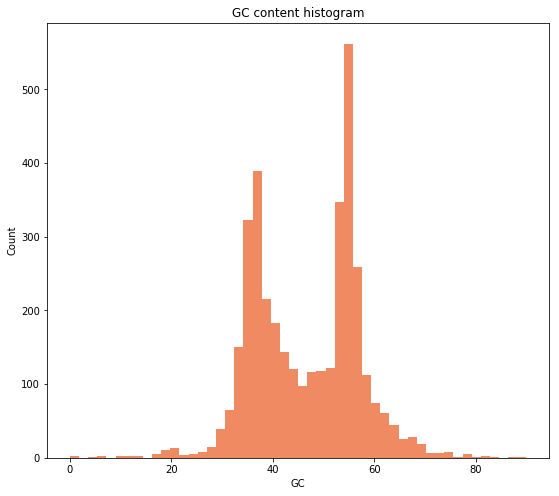

In [5]:
#Setting the plot size
matplotlib.rcParams['figure.figsize'] = (9, 8)

#Building histogram with the gc content column of the dataframe
plt.hist(seq_df['gc_content'], bins=50, color='#ef8a62')
plt.title('GC content histogram')
plt.xlabel('GC')
plt.ylabel('Count')
plt.show()

#### Read length 

The main advantage of using matplotlib to visualize the data is the capability of customize the plots. The same histogram plot function is used to visualize the read length distribution or the average quality of the reads in the set. The range of length distribution is represented in the x axis and the read count in y axis.

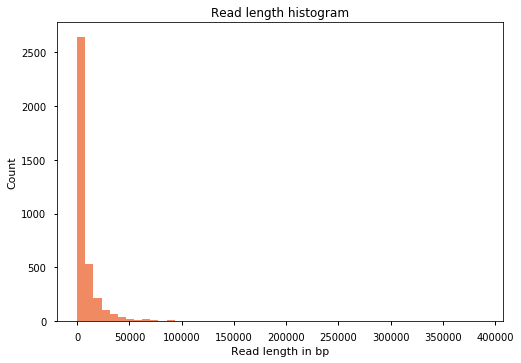

In [6]:
#Customize the plot using the pre-defined style called “ggplot” to emulate ggplot (popular R visualization package) style 
plt.style.use('seaborn-notebook')

#On the plt.hist parameters we can set the number of bins and the bar color using labels as 'blue', 'red', 'yellow'... or using a RGB code.
plt.hist(seq_df['read_length'], bins=50, color='#ef8a62')
plt.title('Read length histogram')
plt.xlabel('Read length in bp')
plt.ylabel('Count')

plt.show()

#### Quality

Using the information of the FASTQ file, the following lines of code will plot the quality distribution. The average quality value assigned to each sequence will be represented on the x axis and the read count on the y axis.

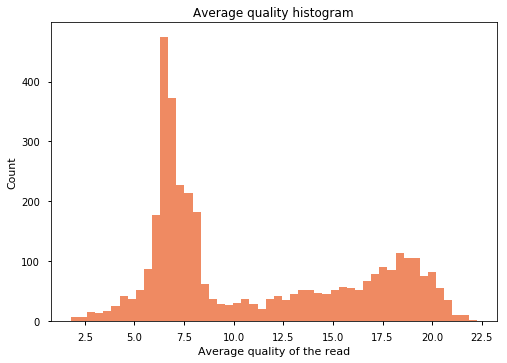

In [7]:
#Only works if input file is in FASTQ format
plt.hist(seq_df['avg_quality'], bins=50, color='#ef8a62')
plt.title('Average quality histogram')
plt.xlabel('Average quality of the read')
plt.ylabel('Count')

plt.show()

#### Represent and analyze in range 

Other subsets of the data can be created to get the statistics or plot a read length histogram of the reads with a GC content within a given range. The “describe” function outputs a table with some statistics of the selected dataframe.

In [8]:
first_range_df = seq_df[(seq_df['gc_content'] > 30) & (seq_df['gc_content'] < 50)]
second_range_df = seq_df[(seq_df['gc_content'] > 55) & (seq_df['gc_content'] < 80)]

first_range_df.describe()

read_length   gc_content  avg_quality
count    1913.000000  1913.000000  1913.000000
mean     6301.520125    39.174907    14.414539
std     17911.515793     4.837827     4.677796
min         5.000000    30.009407     2.000000
25%       909.000000    35.645472    10.645132
50%      2153.000000    37.883598    15.428571
75%      6016.000000    42.377261    18.423237
max    348196.000000    49.993251    22.241614

In this case, two read subsets and matplotlib are used to generate figures with two subplots, each one showing features as read length or average quality for each of the two subsets that were created from the FASTA/FASTQ file.

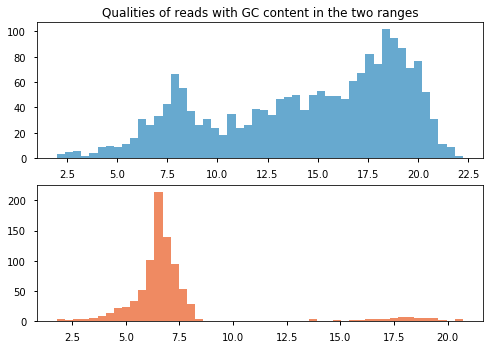

In [9]:
#Only works if input file is in FASTQ format
f, axarr = plt.subplots(2)

axarr[0].hist(first_range_df['avg_quality'], bins=50, color='#67a9cf')
axarr[0].set_title('Qualities of reads with GC content in the two ranges')

axarr[1].hist(second_range_df['avg_quality'], bins=50, color='#ef8a62')


plt.show()

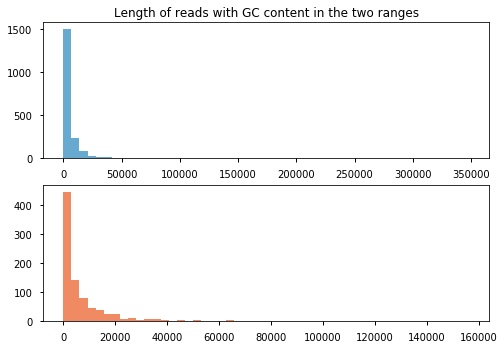

In [10]:
f, axarr = plt.subplots(2)

axarr[0].hist(first_range_df['read_length'], bins=50, color='#67a9cf')
axarr[0].set_title('Length of reads with GC content in the two ranges')

axarr[1].hist(second_range_df['read_length'], bins=50, color='#ef8a62')


plt.show()

### References

[1] Cock, P. J., Antao, T., Chang, J. T., Chapman, B. A., Cox, C. J., Dalke, A., Friedberg, I., Hamelryck, T., Kauff, F., Wilczynski, B., de Hoon, M. J. Biopython: freely available Python tools for computational molecular biology and bioinformatics. Bioinformatics, Volume 25, Issue 11, 1 June 2009, Pages 1422–1423. DOI http://dx.doi.org/10.1093/bioinformatics/btp163